based on https://medium.com/python-in-plain-english/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9

In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from platform import python_version

print(python_version())
import shap
print(shap.__version__)

The scikit-learn version is 0.22.1.
3.7.6
0.37.0


In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
from sklearn.model_selection import train_test_split
import shap
shap.initjs()

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [66]:
# Loading the datasets

#comparsion?
testing = "NovsSoibaq"

X = pd.read_csv('/Users/leboeufa/Documents/Lab/My_Lab/00Proteomics/PP2033_Labside_of_Variation_paper/PP2033/RFpyth/YvMFieldLN.csv', sep=',')

with open('/Users/leboeufa/Documents/Lab/My_Lab/00Proteomics/PP2033_Labside_of_Variation_paper/PP2033/RFpyth/NorthvSouthFieldClass.csv', newline='') as csvfile:
    y = list(csv.reader(csvfile))

y = np.array(y)

y = np.delete(y, 0, 0)



In [67]:
# Building the datasets: training and testing sets. The testing set is made of randomly chosen entries, and 20% of the full dataset
seed=18
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.float64)


In [73]:
%%capture scores --no-stderr


# define the model
rfmo = RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=3, min_samples_split=8, min_samples_leaf=3, oob_score=True, bootstrap=True, random_state=seed)
#, min_samples_split=12, min_samples_leaf=3,
# max_depth: int, default=None: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    # random_state: int or RandomState, default=None :Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features). 
    # max_features: {“auto”, “sqrt”, “log2”}, int or float, default=”auto” :

        #The number of features to consider when looking for the best split:
            # If int, then consider max_features features at each split.
            # If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
            # If “auto”, then max_features=sqrt(n_features).
            # If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
            # If “log2”, then max_features=log2(n_features).
            # If None, then max_features=n_features.

# fit the model
rfmo.fit(X_train, y_train.ravel())

y_pred_test = rfmo.predict(X_test)

# Print accuracy for the training and test sets
print("Accuracy on training set: {:.3f}".format(rfmo.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfmo.score(X_test, y_test)))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print('Accuracy = {:0.2f}%.'.format(accuracy_score(y_test,y_pred_test)))
    
# save
joblib.dump(rfmo, "./" + testing + ".joblib")

with open(testing +str(seed) +'output.txt', 'w') as f:
    f.write(scores.stdout)

# load, no need to initialize the loaded_rf
#loaded_rf = joblib.load("./" + testing + ".joblib")

In [74]:
print("Accuracy on training set: {:.3f}".format(rfmo.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rfmo.score(X_test, y_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))
print('Accuracy = {:0.2f}%.'.format(accuracy_score(y_test,y_pred_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.833
[[ 5  2]
 [ 1 10]]
              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77         7
         1.0       0.83      0.91      0.87        11

    accuracy                           0.83        18
   macro avg       0.83      0.81      0.82        18
weighted avg       0.83      0.83      0.83        18

Accuracy = 0.83%.


In [70]:

#For param hunting, Don't need to run each time. 

from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [50,100,500,2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3,5,10,20],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

CV_rfc = GridSearchCV(estimator=rfmo, param_grid=param_grid, n_jobs = -1, verbose = 2, cv= 3)
CV_rfc.fit(X_train, y_train.ravel())
print(CV_rfc.best_params_)
# save
joblib.dump(CV_rfc.best_params_, "./" + testing + "bestparams.joblib")



Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.9min


{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  6.4min finished


['./NovsSoibaqbestparams.joblib']

In [75]:
#outputs predict values
sampclass=rfmo.predict_proba(X)

np.savetxt(testing +str(seed)+ "SamplesClassified.csv", sampclass, delimiter=",")

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.05 µs


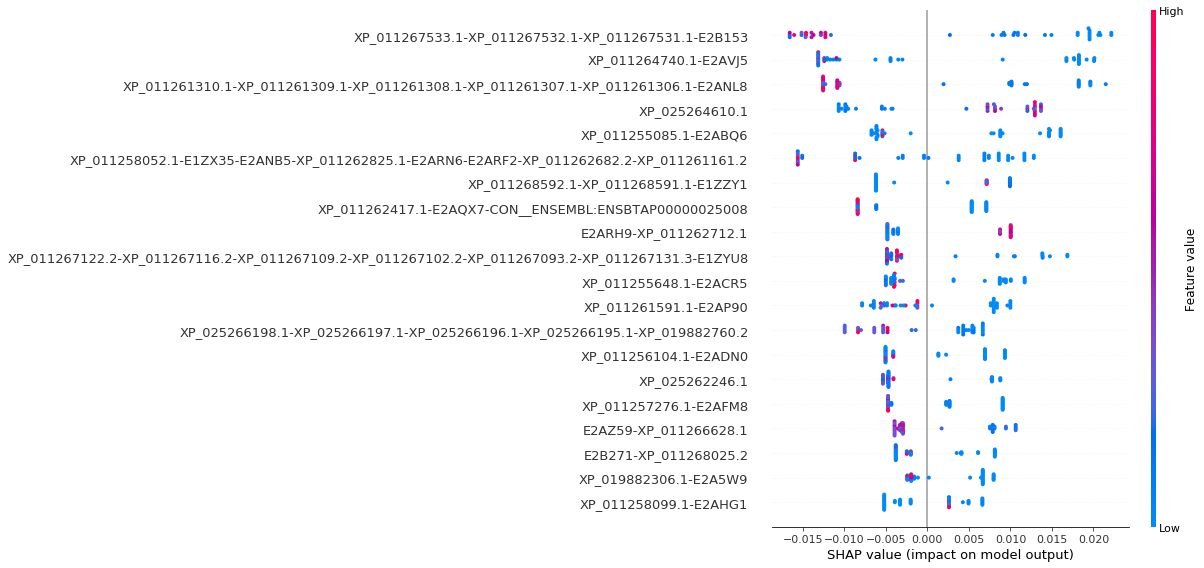

In [76]:
# Let us have a look on SHAP summary plot
from matplotlib import pyplot as plt
%time
samples = X
explainer = shap.TreeExplainer(rfmo)
shap_values = explainer.shap_values(samples)
shap.summary_plot(shap_values[0], samples,show=False)
plt.savefig(testing +str(seed)+ 'pinkblue.pdf'.format(), bbox_inches='tight')


In [321]:
import numpy as np
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
#feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

feature_importance.to_csv(testing +str(seed)+ 'featimp.csv')
feature_importance.head(10)
finext=pd.DataFrame(list(zip(sum(vals))), columns=['feature_importance_vals'])
#fiall=feature_importance

#this and next cell are run on each seed to collect 10 replicates of the RF. 

In [322]:
#fi.append(finext)
fiall=pd.concat([fiall,finext], axis=1)
fiall.to_csv(testing +'allfeatimp.csv')


In [653]:
f=shap.force_plot(explainer.expected_value[0], shap_values[0], X, show=False)
#shap.force_plot(explainer.expected_value[0], shap_values[0], X)

shap.save_html(testing + "forceplot.htm", f)


<Figure size 864x576 with 0 Axes>

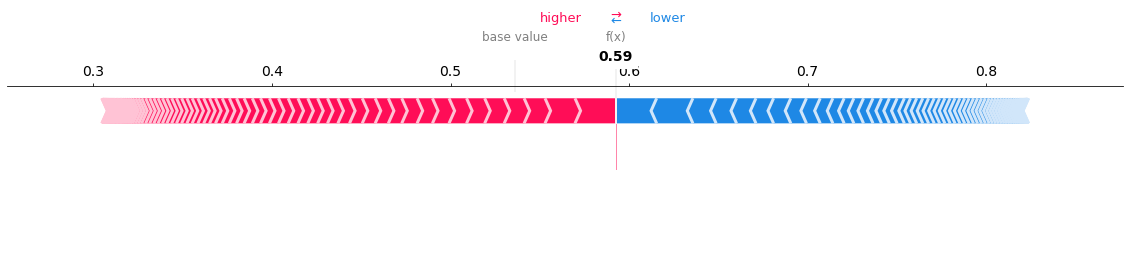

In [660]:
def specific_proteins(model, patient): 
    explainer = shap.TreeExplainer(model) 
    shap_values = explainer.shap_values(patient) 
    shap.initjs() 
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient, matplotlib=True, show=False)

plt.clf()
specific_proteins(rfmo, X.iloc[1]) 
plt.savefig("sample1.png",dpi=150, bbox_inches='tight')

#shap_values.head()

In [718]:
#BINARY MODELS


# A random baseline to compare our predictions to. Flip a coin for each patient.
baseline_preds = np.random.rand(len(y_test))

def report_summary_stats(predictions):
    # Round to binary 0/1 predictions
    pred_labels = predictions.round()
    acc = metrics.accuracy_score(y_test, pred_labels)
    pre = metrics.precision_score(y_test, pred_labels)
    rec = metrics.recall_score(y_test, pred_labels)
    print("Accuracy = {:.1%}, Precision = {:.1%}, Recall = {:.1%}".format(
        acc, pre, rec
    ))
    
print("** Our model **")
report_summary_stats(y_pred_test)
print("** Random baseline **")
report_summary_stats(baseline_preds)
#precision: What proportion of positive identifications was actually correct?
#recall: What proportion of actual positives was identified correctly?

** Our model **
Accuracy = 100.0%, Precision = 100.0%, Recall = 100.0%
** Random baseline **
Accuracy = 55.6%, Precision = 66.7%, Recall = 40.0%


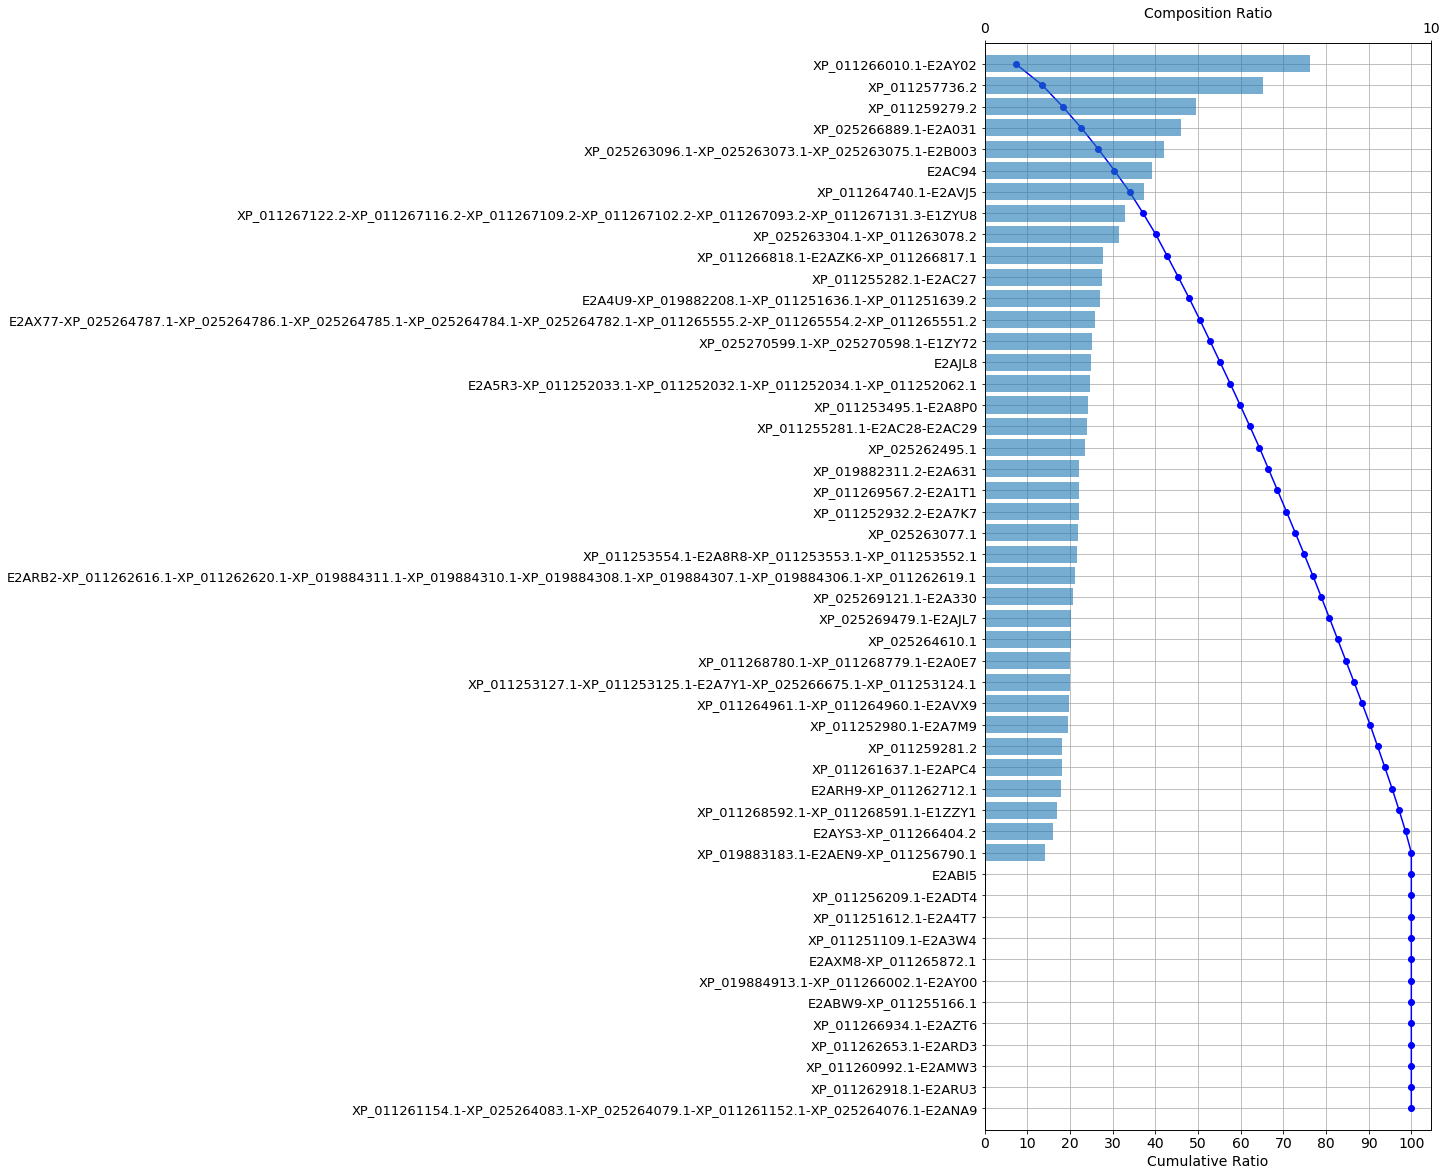

In [814]:

def make_shap_waterfall_plot(shap_values, features, num_display=50):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    
    # Shap waterfall plot
make_shap_waterfall_plot(shap_values[0], samples)
plt.savefig(testing +str(seed)+ 'labyoungwaterfall.pdf'.format(), bbox_inches='tight')



## To download the packages

In [1]:
conda install -c conda-forge shap

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/marie-pierre/anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38h578d9bd_0         3.0 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    shap-0.36.0                |   py38hc5bc63f_0         489 KB  conda-forge
    slicer-0.0.3               |             py_0          14 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/linux-64::pyt

In [3]:
pip install numpy


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.
